In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

In [2]:
new_data = pd.read_csv('Att2CleanData.csv')

In [3]:
x_new_data = new_data.drop(['GoodLoan'], axis=1)
y_new_data = new_data['GoodLoan']

In [4]:
y_new_data.value_counts()

1.0    760344
0.0     56381
Name: GoodLoan, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_new_data, y_new_data, test_size=0.33, random_state=42)

In [8]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_sm, y_sm = sm.fit_sample(X_train, y_train)
unique_rsm, counts_rsm = np.unique(y_sm, return_counts=True)
dict(zip(unique_rsm, counts_rsm))

/home/pizzle/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


{0.0: 509663, 1.0: 509663}

In [10]:
clf = GradientBoostingClassifier(n_estimators=2, learning_rate=1.0,
                                 max_depth=1, random_state=0)

In [11]:
clf.fit(x_sm, y_sm).score(x_sm, y_sm)


0.69560376170135951

In [13]:
scores = cross_val_score(clf, x_sm, y_sm, cv=5)
print(scores)

[ 0.68299275  0.69776226  0.69754643  0.69849017  0.6984215 ]


In [18]:
clf.score(X_test, y_test)

0.94984045710893439

In [14]:
y_true, y_pred = y_test, clf.predict(X_test)

In [15]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.11      0.83      0.20     18839
        1.0       0.98      0.50      0.66    250681

avg / total       0.92      0.52      0.63    269520



In [18]:
from scipy import interp
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

random_state = np.random.RandomState(0)
cv = StratifiedKFold(n_splits=6)
classifier = GradientBoostingClassifier(n_estimators = 2)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

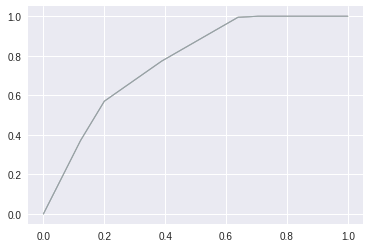

In [19]:
i = 0
for train, test in cv.split(x_sm, y_sm):
    probas_ = classifier.fit(x_sm, y_sm).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

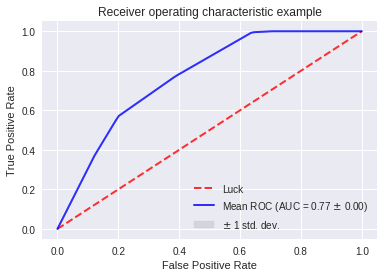

In [20]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()